In [1]:
#!pip install pyyaml==5.1
#!pip install opencv-contrib-python
# python3 -m ipykernel
import torch
import cv2
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
CV2_VERSION = cv2.__version__
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION, ";CV2: ", CV2_VERSION)

torch:  1.10 ; cuda:  cu113 ;CV2:  4.5.4-dev


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

In [5]:
## Import dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train_set", {}, "./Images/flora/annotations/instances_default.json", "./Images/flora/images")

In [6]:
fucus_metadata = MetadataCatalog.get("train_set")

In [7]:
fucus_metadata

namespace(name='train_set',
          json_file='./flora/annotations/instances_default.json',
          image_root='./flora/images',
          evaluator_type='coco')

In [8]:
dataset_dicts = DatasetCatalog.get("train_set")

[11/26 16:28:19 d2.data.datasets.coco]: Loaded 148 images in COCO format from ./flora/annotations/instances_default.json


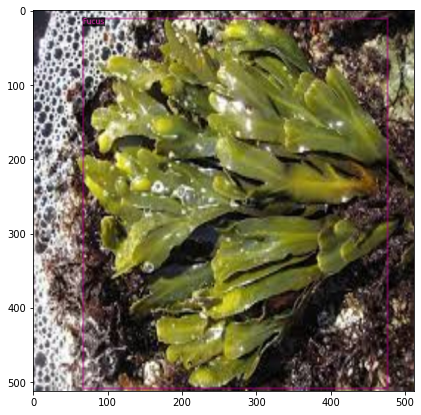

In [9]:
# Visualize dataset
plt.rcParams['figure.figsize'] = [15, 7]
import random
from detectron2.utils.visualizer import Visualizer

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=fucus_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(cv2.cvtColor(vis.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB))

In [11]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

In [10]:
## Train

from detectron2.engine import DefaultTrainer
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("train_set",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00125
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1600
cfg.SOLVER.STEPS = (1000, 1500)     # do not decay learning rate
#cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here. (copied from the official detectron2 tutorial)
cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[11/26 16:28:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[11/26 16:28:32 d2.data.datasets.coco]: Loaded 148 images in COCO format from ./flora/annotations/instances_default.json
[11/26 16:28:32 d2.data.build]: Removed 0 images with no usable annotations. 148 images left.
[11/26 16:28:32 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|   Fucus    | 57           |  Zostera   | 57           | Fuscellaria | 51           |
|            |              |            |              |             |              |
|   total    | 165          |            |              |             |              |
[11/26 16:28:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/26 16:28:32 d2.data.build]: Using training sampler T

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (12, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (12,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, 

[11/26 16:28:33 d2.engine.train_loop]: Starting training from iteration 0


/illukas/home/jgalin/Detectron2/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[11/26 16:28:50 d2.utils.events]:  eta: 0:21:37  iter: 19  total_loss: 2.132  loss_cls: 1.456  loss_box_reg: 0.6717  loss_rpn_cls: 0.009267  loss_rpn_loc: 0.007469  time: 0.8212  data_time: 0.0364  lr: 3.6013e-06  max_mem: 7226M
[11/26 16:29:07 d2.utils.events]:  eta: 0:22:52  iter: 39  total_loss: 2.047  loss_cls: 1.326  loss_box_reg: 0.6667  loss_rpn_cls: 0.01953  loss_rpn_loc: 0.009501  time: 0.8347  data_time: 0.0038  lr: 6.0762e-06  max_mem: 7226M
[11/26 16:29:23 d2.utils.events]:  eta: 0:21:13  iter: 59  total_loss: 1.871  loss_cls: 1.166  loss_box_reg: 0.6877  loss_rpn_cls: 0.006438  loss_rpn_loc: 0.008462  time: 0.8291  data_time: 0.0039  lr: 8.5513e-06  max_mem: 7226M
[11/26 16:29:40 d2.utils.events]:  eta: 0:21:28  iter: 79  total_loss: 1.668  loss_cls: 0.9614  loss_box_reg: 0.6984  loss_rpn_cls: 0.01287  loss_rpn_loc: 0.01089  time: 0.8290  data_time: 0.0040  lr: 1.1026e-05  max_mem: 7226M
[11/26 16:29:57 d2.utils.events]:  eta: 0:21:50  iter: 99  total_loss: 1.53  loss_cls:

[11/26 16:38:41 d2.utils.events]:  eta: 0:12:21  iter: 719  total_loss: 0.5256  loss_cls: 0.09552  loss_box_reg: 0.4272  loss_rpn_cls: 0.0007059  loss_rpn_loc: 0.008491  time: 0.8409  data_time: 0.0038  lr: 9.0226e-05  max_mem: 7226M
[11/26 16:38:57 d2.utils.events]:  eta: 0:12:03  iter: 739  total_loss: 0.4183  loss_cls: 0.1  loss_box_reg: 0.3191  loss_rpn_cls: 0.0004927  loss_rpn_loc: 0.007334  time: 0.8408  data_time: 0.0042  lr: 9.2701e-05  max_mem: 7226M
[11/26 16:39:14 d2.utils.events]:  eta: 0:11:47  iter: 759  total_loss: 0.5661  loss_cls: 0.1079  loss_box_reg: 0.454  loss_rpn_cls: 0.0009849  loss_rpn_loc: 0.007072  time: 0.8408  data_time: 0.0039  lr: 9.5176e-05  max_mem: 7226M
[11/26 16:39:31 d2.utils.events]:  eta: 0:11:30  iter: 779  total_loss: 0.4999  loss_cls: 0.07604  loss_box_reg: 0.3988  loss_rpn_cls: 0.0008155  loss_rpn_loc: 0.007679  time: 0.8409  data_time: 0.0041  lr: 9.7651e-05  max_mem: 7226M
[11/26 16:39:48 d2.utils.events]:  eta: 0:11:13  iter: 799  total_loss

[11/26 16:48:16 d2.utils.events]:  eta: 0:02:49  iter: 1399  total_loss: 0.2411  loss_cls: 0.03796  loss_box_reg: 0.1957  loss_rpn_cls: 0.0003231  loss_rpn_loc: 0.005717  time: 0.8426  data_time: 0.0045  lr: 0.000125  max_mem: 7226M
[11/26 16:48:33 d2.utils.events]:  eta: 0:02:32  iter: 1419  total_loss: 0.2275  loss_cls: 0.0361  loss_box_reg: 0.1864  loss_rpn_cls: 5.659e-05  loss_rpn_loc: 0.004169  time: 0.8427  data_time: 0.0043  lr: 0.000125  max_mem: 7226M
[11/26 16:48:50 d2.utils.events]:  eta: 0:02:15  iter: 1439  total_loss: 0.2465  loss_cls: 0.04606  loss_box_reg: 0.1975  loss_rpn_cls: 0.000612  loss_rpn_loc: 0.00571  time: 0.8425  data_time: 0.0039  lr: 0.000125  max_mem: 7226M
[11/26 16:49:07 d2.utils.events]:  eta: 0:01:59  iter: 1459  total_loss: 0.2151  loss_cls: 0.04148  loss_box_reg: 0.164  loss_rpn_cls: 9.529e-05  loss_rpn_loc: 0.004865  time: 0.8426  data_time: 0.0042  lr: 0.000125  max_mem: 7226M
[11/26 16:49:23 d2.utils.events]:  eta: 0:01:42  iter: 1479  total_loss:

In [12]:
# Validation dataset
## Import dataset
from detectron2.data.datasets import register_coco_instances
register_coco_instances("validation_set", {}, "./Images/fucus_zostera_val/annotations/instances_default.json", "./Images/fucus_zostera_val/images")

In [13]:
validation_metadata = MetadataCatalog.get("validation_set")
validation_metadata

namespace(name='validation_set',
          json_file='./fucus_zostera_val/annotations/instances_default.json',
          image_root='./fucus_zostera_val/images',
          evaluator_type='coco')

In [14]:
dataset_dicts_val = DatasetCatalog.get("validation_set")

[11/26 16:51:47 d2.data.datasets.coco]: Loaded 98 images in COCO format from ./fucus_zostera_val/annotations/instances_default.json


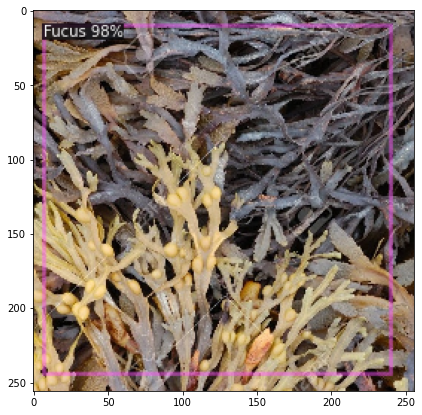

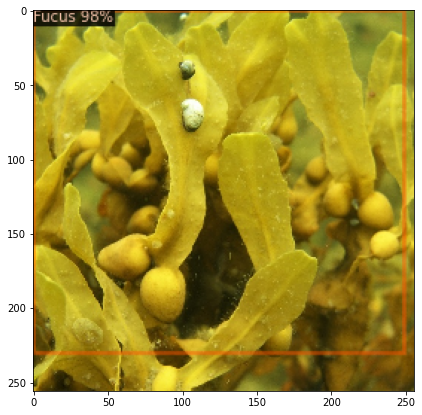

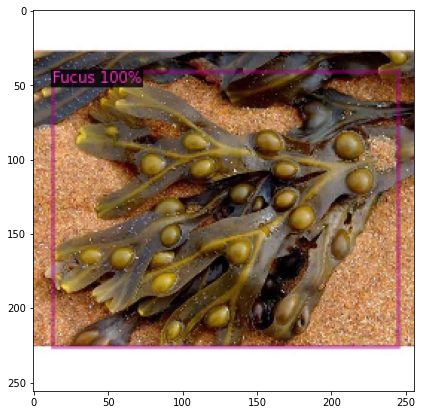

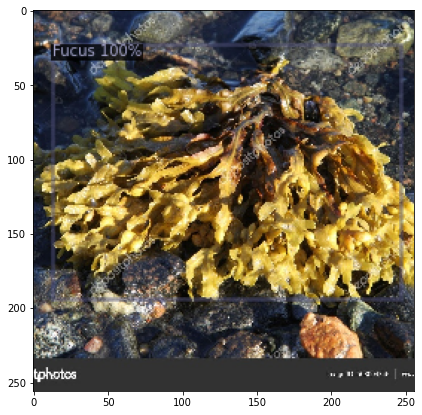

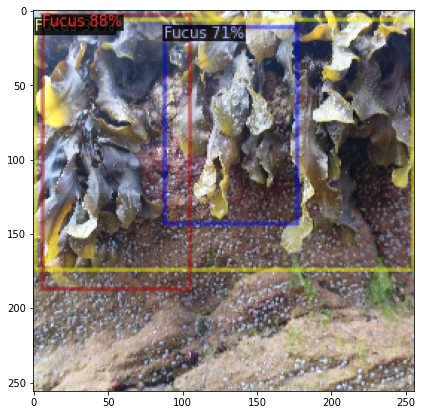

In [19]:
## Inference
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
predictor = DefaultPredictor(cfg)
from detectron2.utils.visualizer import ColorMode
from detectron2.data.datasets import load_coco_json

for d in random.sample(dataset_dicts_val, 5):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
         metadata = validation_metadata,
        scale=0.5)
        #instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure()
    plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1],cv2.COLOR_BGR2RGB))

In [ ]:
# Other validation matrix
pred_box = outputs["instances"].pred_boxes.tensor.cpu().numpy()
confidence = outputs["instances"].scores.cpu().numpy()


In [16]:
## Evaluation test set
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("validation_set", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "validation_set")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [11/26 16:53:05 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/26 16:53:05 d2.data.datasets.coco]: Loaded 98 images in COCO format from ./fucus_zostera_val/annotations/instances_default.json
[11/26 16:53:05 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category   | #instances   |
|:----------:|:-------------|:----------:|:-------------|:-----------:|:-------------|
|   Fucus    | 61           |  Zostera   | 41           | Fuscellaria | 0            |
|            |              |            |              |             |              |
|   total    | 102          |            |              |             |              |
[11/26 16:53:05 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[1

In [17]:
## Evaluation train set
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("train_set", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "train_set")
print(inference_on_dataset(trainer.model, val_loader, evaluator))

WARNING [11/26 16:53:58 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[11/26 16:53:58 d2.data.datasets.coco]: Loaded 148 images in COCO format from ./flora/annotations/instances_default.json
[11/26 16:53:58 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/26 16:53:58 d2.data.common]: Serializing 148 elements to byte tensors and concatenating them all ...
[11/26 16:53:58 d2.data.common]: Serialized dataset takes 0.04 MiB
[11/26 16:53:58 d2.evaluation.evaluator]: Start inference on 148 batches
[11/26 16:54:00 d2.evaluation.evaluator]: Inference done 11/148. Dataloading: 0.0006 s/iter. Inference: 0.1033 s/iter. Eval: 0.0001 s/iter. Total: 0.1041 s/iter. ETA=0:00:14
[11/26 16:54:05 d2.evaluation.evaluator]: Inference done 60/148. Dataloading: 0.0007 s/iter. Inference: 0.1030 

In [18]:
## Saving the model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

In [ ]:
# Load model
import torch
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.MODEL.WEIGHTS = "./output/model_final.pth"


In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [2]:
torch.cuda.is_available()



True